<h2><u>Clustering <u><h2>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
import warnings
warnings.filterwarnings('ignore')
plt.close('all')
import time
start_time = time.time()
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,fbeta_score
from sklearn.metrics import f1_score,v_measure_score
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
sns.set()

In [9]:
#%% Create dataframe
data = pd.read_csv("pulsar_stars.csv")
#view first 5 rows in df
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


We would for first part of our implementation, treat it as a unlabelled dataset and try to run clustering algorithms to find out the distinct group of data points namely:

1. PCA
2. Agglomerative Clustering
3. KMeans

PCA - Principal Component Analysis
It is a precursor step to any analysis that we may subject to our dataset. The above dataset has decent dimensional feature space consisting of 8 features. In such a high-dimensional space, Euclidean distances tend to become inflated and meaningless. This can severely impact our algorithms performance. Such a situation demands more data to train our model and this problem is called the 'Curse of Dimensionality'.

The PCA algorithm solves this problem by finding out the features that explain the maximum variance. So, instead of training our models over 8 features we will be training them over 2 features that explain the maximum variance.

 Together, the two components contain 78.0 % of the information


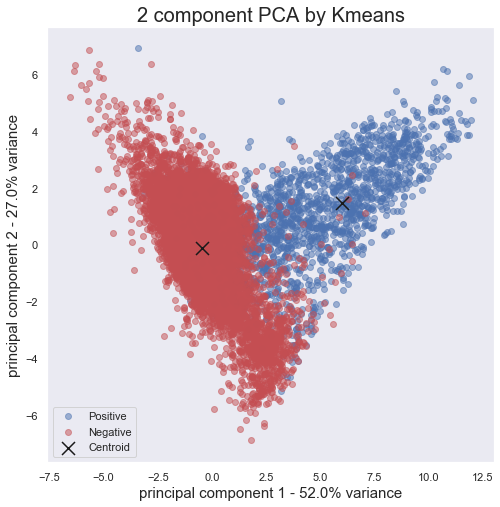

In [11]:
cols = list(data.columns)
features = cols
features.remove('target_class')
# Normalization
X=data[features]
X = StandardScaler().fit_transform(X)
Y=data.target_class
# Split dataset to 60% training and 40% testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
# First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)
#print(reduced_data[:10])  # print upto 10 elements
reduced_data.shape
principalDf = pd.DataFrame(data = reduced_data, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, data[['target_class']]], axis = 1)
fig = plt.figure(figsize = (8,8))
PCA1='principal component 1 - '+str(100*round(pca.explained_variance_ratio_[0],2))+"% variance"
PCA2='principal component 2 - '+str(100*round(pca.explained_variance_ratio_[1],2))+"% variance"
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(PCA1, fontsize = 15)
ax.set_ylabel(PCA2, fontsize = 15)
ax.set_title('2 component PCA by Kmeans', fontsize = 20)
targets = [1,0]
colors = ['b', 'r']
pca.explained_variance_ratio_
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target_class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color,alpha=0.5)
ax.grid()
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(reduced_data)
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='k', zorder=10)
ax.legend(["Positive","Negative","Centroid"])
print(" Together, the two components contain",str(100*round(sum(pca.explained_variance_ratio_),2)),"% of the information")

Average silhouette method computes the average silhouette of observations for different values of k. The optimal number of clusters k is the one that maximize the average silhouette over a range of possible values for k.

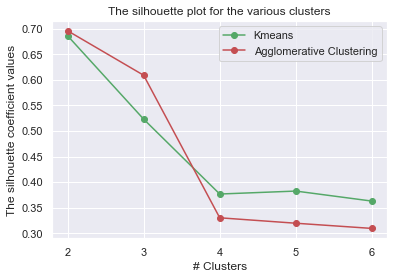

In [12]:
results_KMeans=[]
results_AC_n=[]
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    AC_n=AgglomerativeClustering(n_clusters=n_clusters)
    Kmeans_n = KMeans(n_clusters=n_clusters)
    clusterers=[Kmeans_n,AC_n]
    cluster_names=["KMeans","Agglomerative Clustering"]
    for clusterer in clusterers:
        cluster_labels = clusterer.fit_predict(reduced_data)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(reduced_data, cluster_labels)
        if cluster_names[clusterers.index(clusterer)]=="KMeans":
            results_KMeans.append(silhouette_avg)
        else:
            results_AC_n.append(silhouette_avg)
fig = plt.figure()
ax = plt.axes()
ax.plot(range_n_clusters,results_KMeans,'-og', label='Kmeans')
ax.plot(range_n_clusters,results_AC_n,'-or', label='Agglomerative Clustering')
ax.set_title("The silhouette plot for the various clusters")
ax.set_ylabel("The silhouette coefficient values")
ax.set_xticks(range_n_clusters)
ax.set_xticklabels(range_n_clusters)
ax.set_xlabel("# Clusters")
ax.legend()
ax.grid(True)

Our data has groudtruth, we will use it to for the following external validity measures:
    1. Pair-wise measure:
        1.1. Rand statistics
        1.2. Jaccard coefficient
        1.3. Fowlkes-Mallows 
    2. Matching based measures - F-Measure
    3. Entropy based measure - Conditional Entropy

Total number of 5 different external validity measures.
        

In [13]:
from sklearn.metrics import jaccard_score,fowlkes_mallows_score,precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.metrics.cluster import adjusted_rand_score
X_train, X_test, y_train, y_test = train_test_split(reduced_data, Y, test_size=0.2, random_state=42)
AC_n=AgglomerativeClustering(n_clusters=2)
Kmeans_n = KMeans(n_clusters=2)
clusterers=[Kmeans_n,AC_n]
cluster_names=["KMeans","Agglomerative Clustering"]
fit_results=[]
for clusterer in clusterers:   
    clusterer.fit(X_train, y_train)
    y_pred=clusterer.fit_predict(X_test)
    Rand=adjusted_rand_score(y_test, y_pred)
    jaccard=jaccard_score(y_test, y_pred)
    FM=fowlkes_mallows_score(y_test, y_pred)
    cond_entropy=v_measure_score(y_test, y_pred)
    F_score=f1_score(y_test, y_pred)
    fit_results.append([Rand,jaccard,FM,F_score,cond_entropy])
results_table=pd.DataFrame(fit_results,
                           columns=['Rand', 'jaccard', 'FM',"cond_entropy","F_score"],
                           index=cluster_names).round(2)

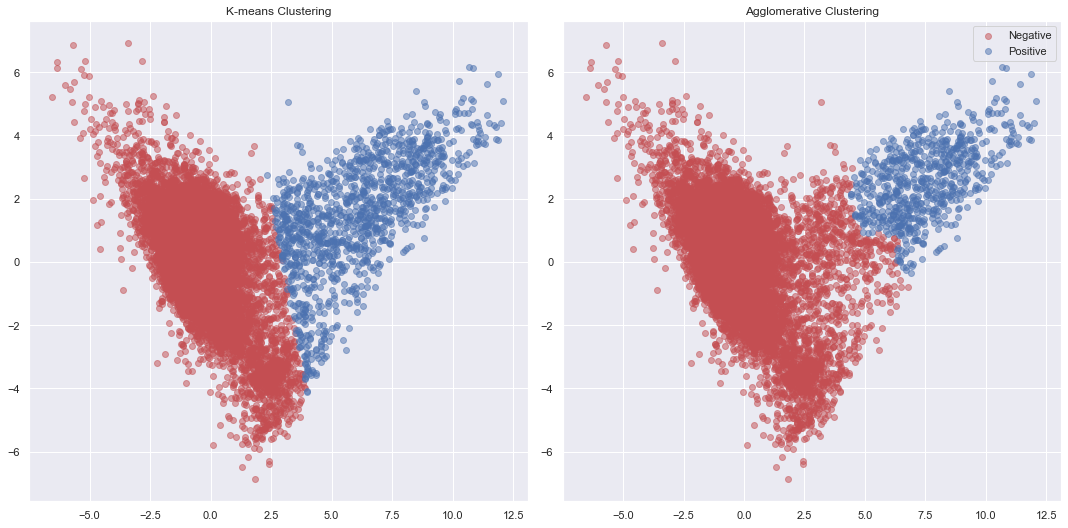

In [14]:
from matplotlib.pyplot import cm 
n=2
colors = ['r','b']
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))

km = KMeans(n_clusters= n , random_state=0)
y_km = km.fit_predict(reduced_data)

for i in range(n):
    ax1.scatter(reduced_data[y_km==i,0], reduced_data[y_km==i,1], c=colors[i], marker='o',alpha=0.5)   
ax1.set_title('K-means Clustering')


ac = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='complete')
y_ac = ac.fit_predict(reduced_data)

for i in range(n):
    ax2.scatter(reduced_data[y_ac==i,0], reduced_data[y_ac==i,1], c=colors[i], marker='o',alpha=0.5)
ax2.set_title('Agglomerative Clustering')
# Put a legend below current axis
plt.legend(["Negative","Positive"])
    
plt.tight_layout()

plt.show()
